In [15]:
%load_ext tensorboard
import datetime, os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.initializers import RandomNormal, HeNormal, GlorotNormal, VarianceScaling, HeUniform, GlorotUniform
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, RMSprop
from tensorflow.keras.utils import to_categorical

from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import confusion_matrix

# Show multiple outputs of one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

# tf.config.list_physical_devices('GPU')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [414]:
# %reload_ext tensorboard

## Load a dataset


In [16]:
(ds_train, ds_test), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

# Input shape. This is not the actual shape of images in mnist. Actual shape is (28, 28, 1)
img_shape = ds_info.features['image'].shape
print(ds_info.citation.title())
print('Image shape:', img_shape)
print('Train dataset examples:', f'{ds_info.splits["train"].num_examples:,}')
print('Test dataset examples:', f'{ds_info.splits["test"].num_examples:,}')


@Online{Clanuwat2018Deep,
  Author       = {Tarin Clanuwat And Mikel Bober-Irizar And Asanobu Kitamoto And Alex Lamb And Kazuaki Yamamoto And David Ha},
  Title        = {Deep Learning For Classical Japanese Literature},
  Date         = {2018-12-03},
  Year         = {2018},
  Eprintclass  = {Cs.Cv},
  Eprinttype   = {Arxiv},
  Eprint       = {Cs.Cv/1812.01718},
}
Image shape: (28, 28, 1)
Train dataset examples: 60,000
Test dataset examples: 10,000


## Build training and evaluation pipelines

In [33]:
batchAdadelta = 128
batchAdagrad = 64
ds_train_f64 = ds_train.map(lambda image, label : (tf.cast(image, tf.float64) / 255., label), num_parallel_calls=tf.data.AUTOTUNE)\
                       .cache()\
                       .shuffle(ds_info.splits['train'].num_examples)\
                       .batch(batchAdagrad)\
                       .prefetch(tf.data.AUTOTUNE)

ds_test_f64 = ds_test.map(lambda image, label : (tf.cast(image, tf.float64) / 255., label), num_parallel_calls=tf.data.AUTOTUNE)\
                     .cache()\
                     .batch(10000)\
                     .prefetch(tf.data.AUTOTUNE)


#### Default with initialization, dropout and batch normalization

In [30]:
def prepareNetAdadelta(model):
    kernel_regularizer = regularizers.l2(1e-4)
    
    model.add(Flatten(input_shape=img_shape))
    
    for i in range(6):
        model.add(Dense(units=512, kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Activation(activation='relu'))
    
    model.add(Dense(10, activation='softmax'))
    return model

In [32]:
def prepareNetAdagrad(model):
    kernel_regularizer = regularizers.l2(1e-3)
    
    model.add(Flatten(input_shape=img_shape))
    
    for i in range(6):
        model.add(Dense(units=512, kernel_initializer='glorot_uniform', kernel_regularizer=kernel_regularizer))
        model.add(BatchNormalization())
        model.add(Activation(activation='relu'))
    
    model.add(Dense(10, activation='softmax'))
    return model

## Compile a model using a specified optimizer

In [34]:
def compileSequentialModel(optimizer):
    model = Sequential()
    prepareNetAdagrad(model)
    model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(from_logits=False), metrics=[SparseCategoricalAccuracy()])
    model.summary()
    return model

## Run a simulation, using the specified optimizer, and return history data for plotting it later

In [23]:
def simulate(ds_train, ds_test, optimizer, epochs=10):
    tensorboard_callback = TensorBoard(os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), histogram_freq=1) 
    
    # Compile and fit
    model = compileSequentialModel(optimizer)
    return model, model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[tensorboard_callback])

### Helper method used to subplot a history diagram (accuracy / loss)

In [24]:
def plotHistory(hist, histDotted, histLabel, histDottedLabel, ylabel, title='', color='', index=0):
    def adjust_lightness(color, amount=1.7):
        import matplotlib.colors as mc
        import colorsys
        try:
            c = mc.cnames[color]
        except:
            c = color
        
        if c is None or (isinstance(c, str) and c == ''):
            return ''
        
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
    if index > 0:
        plt.subplot(1, 2, index)
    
    # Smooth the line using gaussian blur
    lastValBeforeSmooth = hist[-1]
    hist = gaussian_filter1d(hist, sigma=1.2)
    histDotted = gaussian_filter1d(histDotted, sigma=1.2)
    plt.plot(histDotted, '.--', c=adjust_lightness(color), label=histDottedLabel)
    plt.plot(hist, '.-', c=color, label=histLabel)
    plt.ylim([0, max(1, max(np.max(hist), np.max(histDotted)) + 0.2)])
    plt.title(title + ' {:.4f}'.format(lastValBeforeSmooth), fontsize=26, color='blue')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend()
    plt.grid()

In [25]:
def plotConfusionMatrix(y_test, y_predict):
    conf_mat = confusion_matrix(y_test, y_predict)
    plt.style.use('seaborn-deep')
    plt.figure(figsize=(10, 10))
    heatmap = sns.heatmap(conf_mat, annot=True, annot_kws={'size': 15}, linewidths=0.5, fmt="d", cmap=plt.cm.Blues)
    heatmap.set_xlabel('Predicted', fontsize=16)
    heatmap.set_ylabel('Actual', fontsize=16)
    heatmap.xaxis.set_ticks_position('top')
    heatmap.xaxis.set_label_position('top')
    plt.title('\nConfusion Matrix on KMNIST predictions\n', fontweight='bold', fontsize=26, color='tab:blue')
    plt.show()

### Plot accuracy and loss diagram for both model and validation

In [26]:
def plotAccuracyAndLoss(model, history, ds_test):
    def datasetLabelToNdArray(ds):
        npArrIter = tfds.as_numpy(ds)
        y = []
        for row in npArrIter:
            y.append(row[1])

        y = np.array(y).reshape((10000,))
        return y
    
    # Plot accuracy
    accuracyData = history.history['sparse_categorical_accuracy']
    valAccuracyData = history.history['val_sparse_categorical_accuracy']
    lossData = history.history['loss']
    valLossData = history.history['val_loss']
    
    fig = plt.figure(figsize=(25, 8))
    plotHistory(valAccuracyData, accuracyData, 'validation', 'training', ylabel='Accuracy', title='Accuracy:', color='tab:blue', index=1)
    plotHistory(valLossData, lossData, 'validation', 'training', ylabel='Loss', title='Loss:', color='tab:red', index=2)
    
    # Predict results on test data set, to draw confusion matrix
    y_test = datasetLabelToNdArray(ds_test)
    y_predict = model.predict(ds_test)
    
    # Get the index of maximum value in the encoded vector
    y_predict = np.argmax(y_predict, axis=1)
    plotConfusionMatrix(y_test, y_predict)

# Perform a simulation, print summary and plot history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               401920    
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                      

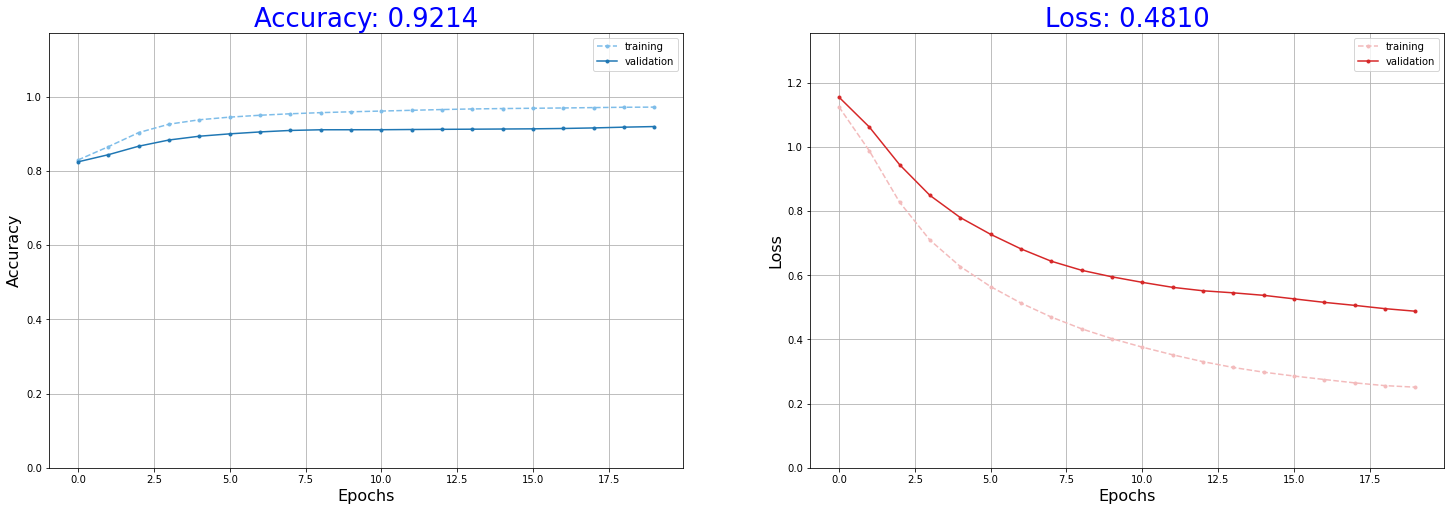

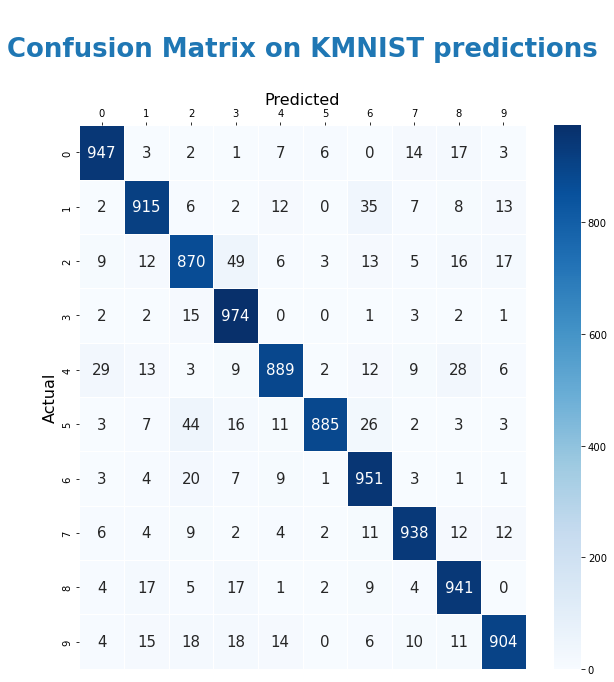

In [28]:
modelAdadelta, historyAdadelta = simulate(ds_train_f64, ds_test_f64, Adadelta(learning_rate=1.0), 20)
plotAccuracyAndLoss(modelAdadelta, historyAdadelta, ds_test_f64)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_35 (Dense)            (None, 512)               401920    
                                                                 
 batch_normalization_30 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_31 (Bat  (None, 512)              2048      
 chNormalization)                                     

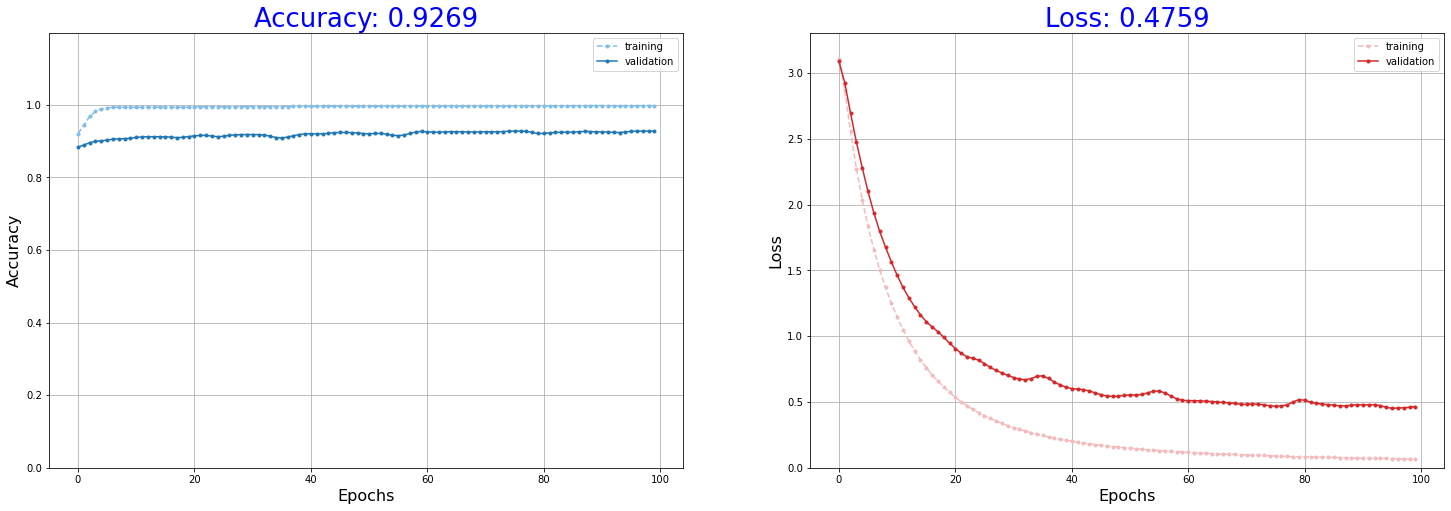

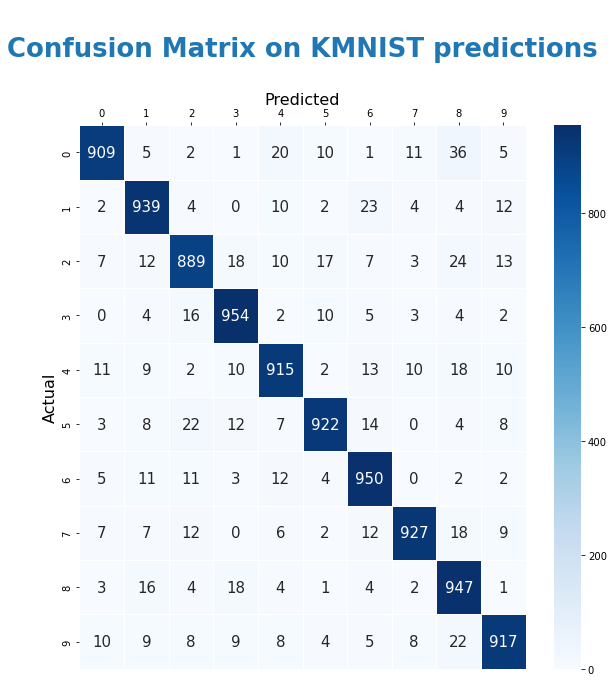

In [39]:
modelAdagrad, historyAdagrad = simulate(ds_train_f64, ds_test_f64, Adagrad(learning_rate=1e-2), 100)
plotAccuracyAndLoss(modelAdagrad, historyAdagrad, ds_test_f64)

### Create Tensorboard 

In [40]:
from tensorboard import notebook
from tensorboard import manager

print(manager._get_info_dir())
notebook.list()

C:\Users\hadrian\AppData\Local\Temp\.tensorboard-info
Known TensorBoard instances:
  - port 6006: logdir logs (started 3 days, 3:21:54 ago; pid 5824)


In [42]:
%tensorboard --logdir logs --host localhost
from tensorboard import notebook

Reusing TensorBoard on port 6006 (pid 5824), started 3 days, 3:22:17 ago. (Use '!kill 5824' to kill it.)